# CD7 Quality control figure for paper

In [1]:
# %load ../common_.py
import sys
sys.path.append("../../..")
from workflow.common import *

In [87]:
from aicsimageio import AICSImage
import cellpose
import numpy
import skimage
import seaborn
from skimage.measure import regionprops, regionprops_table, approximate_polygon

In [86]:
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
import geopandas

In [66]:
from matplotlib.colors import Normalize

In [3]:
from typing import Optional, List, Any, Mapping
from cellpose import models
from skimage.measure import regionprops
import torch
from skimage.morphology import white_tophat, disk

def segment_block(
    block,
    *,
    gpu_accelerated: Optional[bool] = False,
    cell_diameter: Optional[int] = None,
    dapi_channel_index: Optional[int] = None,
    segmentation_channel_index: int,
    **kwargs
):
        
    model = models.Cellpose(gpu=False, model_type='cyto2')

    cp_input = block[segmentation_channel_index]
    cells, _, _, _ = model.eval(
        x=cp_input,
        channels=[0, 0],
        diameter=cell_diameter,
        batch_size=16
    )

    labeled_mask = numpy.repeat(cells[numpy.newaxis], block.shape[0], axis=0)

    if dapi_channel_index is not None:
        cp_input = block[dapi_channel_index]
        cp_input = white_tophat(cp_input, footprint=disk(25))
        nuclei, _, _, _ = model.eval(
            x=cp_input,
            channels=[0, 0],
            diameter=cell_diameter,
            batch_size=16
        )

        # assign over-segmented nuclei to parent cells
        nuclei_mask = numpy.zeros_like(cells)
        for i in numpy.unique(cells)[1:]:
            idx = numpy.unique(nuclei[cells == i])[1:]
            _, counts = numpy.unique(nuclei[cells == i], return_counts=True)
            idx = idx[(counts[1:] / (cells == i).sum()) > 0.1]
            nuclei_mask[numpy.isin(nuclei, idx) & (cells == i)] = i
        labeled_mask[dapi_channel_index] = nuclei_mask

    return labeled_mask

## Load processed frame

In [205]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203221745/")

In [206]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()

In [207]:
df = df.set_index(["meta_panel", "meta_replicate", "meta_P", "meta_id"])
df = df.sort_index()

In [208]:
# for now only continue with objects from panel D
df = df.loc["D"]
df.shape

(45942, 1494)

# Cellpose

In [8]:
im = AICSImage(df.iloc[0]["meta_path"])
im.set_scene(df.iloc[0]["meta_scene"])

In [9]:
mask = segment_block(
    numpy.max(im.get_image_data("ZCXY", C=[0, 6]), axis=0),
    dapi_channel_index= 0,
    segmentation_channel_index = 1
)

In [75]:
seg_polygons = geopandas.GeoDataFrame([dict(id=r.label, geometry=Polygon(r.coords)) for r in regionprops(mask[1])])
dapi_polygons = geopandas.GeoDataFrame([dict(id=r.label, geometry=Polygon(r.coords)) for r in regionprops(mask[0])])

In [219]:
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

def mask_to_polygons_layer(mask):
    # https://rocreguant.com/convert-a-mask-into-a-polygon-for-images-using-shapely-and-rasterio/1786/
    all_polygons = []
    all_values = []
    for shape, value in features.shapes(mask.astype(numpy.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        all_polygons.append(shapely.geometry.shape(shape))
        all_values.append(int(value))

    return geopandas.GeoDataFrame(dict(geometry=all_polygons), index=all_values)

seg_polygons = mask_to_polygons_layer(mask[1])
dapi_polygons = mask_to_polygons_layer(mask[0])

In [226]:
border_margin = 30
w, h = 1144, 1144

def color(r):
    return plt.get_cmap("Set1")(numpy.random.choice(numpy.arange(0, 8)))

def border_color(r):
    return plt.get_cmap("tab10")(3) if r else (1, 1, 1 ,1)

def linewidth(r):
    return 1 if r else 0.5

def is_in_border(r):
    r = r.centroid
    if (r.x - border_margin < 0) or (r.x + border_margin > h):
        return True
    if (r.y - border_margin < 0) or (r.y + border_margin > w):
        return True
    return False

In [227]:
seg_polygons["border"] = seg_polygons.geometry.map(is_in_border)
dapi_polygons["border"] = dapi_polygons.geometry.map(is_in_border)
seg_polygons["color"] = seg_polygons.border.map(color)
dapi_polygons["color"] = seg_polygons["color"]
seg_polygons["border_color"] = seg_polygons.border.map(border_color)
dapi_polygons["border_color"] = dapi_polygons.border.map(border_color)
seg_polygons["linewidth"] = seg_polygons.border.map(linewidth)
dapi_polygons["linewidth"] = dapi_polygons.border.map(linewidth)

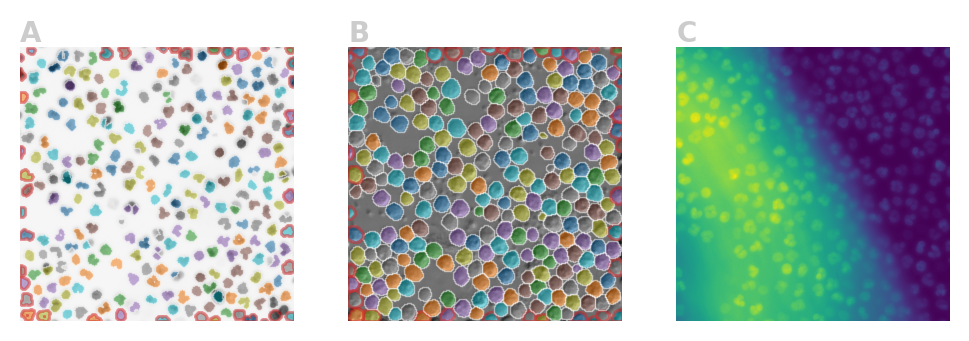

In [237]:
im.set_scene(df.iloc[0]["meta_scene"])
pixels = numpy.max(im.get_image_data("ZCXY", C=[0, 6]), axis=0)
fig, axes = plt.subplots(1, 3, dpi=200, squeeze=False)
axes = axes.ravel()
for ax, p, o, c in zip(axes, pixels, [dapi_polygons, seg_polygons], [Normalize(0, 5000), None]):
    ax.imshow(p, cmap="Greys", origin="lower", norm=c)
    o.plot(ax=ax, alpha=.5, column="color", edgecolor=o.border_color, linewidth=o.linewidth)
    ax.set_axis_off()
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    
im.set_scene("P1-D2")
pixels = numpy.max(im.get_image_data("ZCXY", C=[0]), axis=0)
axes[2].imshow(pixels[0])
axes[2].set_axis_off()

axes[0].text(s="A", x=0, y=1, fontsize=10, weight="heavy", alpha=0.2, transform=axes[0].transAxes, va="bottom")
axes[1].text(s="B", x=0, y=1, fontsize=10, weight="heavy", alpha=0.2, transform=axes[1].transAxes, va="bottom")
axes[2].text(s="C", x=0, y=1, fontsize=10, weight="heavy", alpha=0.2, transform=axes[2].transAxes, va="bottom")

plt.savefig(data_dir / "figures/segmentation_example.png", bbox_inches='tight', pad_inches=0, dpi=200)